## Assignment A5: Signal Representation

Please follow the General Assignment Guidelines document on canvas under the Pages for completing this assignment.  When you have completed the assignment, please follow the Submission Instructions.

### Overview

This assignment focuses on concepts in signal representation and source separation.

### Readings

The following material provides both background and additional context.  It linked in the Canvas page for this assignment.  Refer to these for a more detailed explanation and formal presentation of the concepts in the exercises.

- Müller (2015) *Fundamentals of Music Processing*. Ch. 2 Fourier Analysis of Signals.
- Prandoni and Vetterli (2008) *Signal Processing for Communications*.  Ch. 4 Fourier Analysis.

### Learning objectives

- Construct basis functions of a discrete Fourier transform (DFT) 
- Demonstrate how basis functions are defined using the complex exponential.
- Plot examples of the real and imaginary pairs of the DFT.
- Demonstrate how the Fourier transform can be implemented as a matrix-vector operation.
- Compare and benchmark this implementation to the standard `fft` function.
- Use the inverse Fourier transform to synthesize bandpass noise.
- Illustrate 2D transforms by recovering and plotting their 2D basis functions.

***
## Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time


### 1. Basis functions of the discrete Fourier transform

In the last assignment you used the Fourier transform to form a represenatation of signals in terms of frequencies.  Here we will construct the discrete Fourier transform from the mathematics as an exercise in basis representation and to see how it relates to a matrix-vector operation.

The discrete Fourier transform (DFT) decomposes a signal of length $N$ into a set of $N$ frequencies.  We will now see how these form a **basis** and provide an equivalent (i.e. invertible) representation of arbitrary signals of length $N$.

A basis is a set of linearly independent vectors than **span** the space, i.e. it is possible to represent all signals of length $N$.  If the vectors are also mutually orthogonal with unit norm, this is called an **orthonormal basis**, which is the case for most common transforms.  In linear algebra terms, this is equivalent to defining different axes for the same data.  Here, we are going from the axes of sample values to axes of frequency components.

The individual basis functions in the discrete Fourier transform are defined by

$$
w_k[n] = \exp(j\, \omega_k n), \quad n = 0, \ldots, N-1
$$

Note here we are using the complex exponential representation discussed in A4.The basis functions must satisfy certain conditions in order to form a proper basis.  Each frequency contains a whole number of periods over $N$ samples, so it is a periodic function, i.e. $w_k[0] = w_k[N]$ = 1.  



The frequency components of the DFT are defined by

$$
w_k[n] = \exp \left(j \frac{2\pi k}{N} n \right), \quad k = 0, \ldots, N-1
$$

For each basis functions to be normalized, we would need to scale by $1/\sqrt{N}$, but we will postpone this until we write the transformation in matrix form.

Note that the frequencies are defined by $(2\pi/N)k$, i.e. a fraction of $2\pi$, so each frequency is a multiple of $2\pi/N$.  For $k=N$, this "wraps around" on the unit circle.  It is also true that $k=N-1$ is equivalent to $k=-1$, since we are either adding or subtracting $2\pi/N$.

This fraction is then further multiplied by $n$, so the functions $\exp(j 2\pi k n / N)$ are repeatedly wrapping around the unit circle giving the cosine (real) and sine (imaginary) values until they complete a full period of the function represented by the basis at $n=N$.  At that point all frequencies are a multiple of $2\pi$.  


#### 1a. Visualizing the Complex Representation of a Fourier Basis

The complex representation can be visualized by plotting values of $\exp(j2\pi k/N)$ on the unit circle (for reference, see figure 4.1 in Prandoni and Vetterli or figure 2.4 in Müller).  For the lowest frequency $k=1/N$, the values for $n=0, \ldots, N-1$ simply trace out the discrete cosine and sine functions, each completing a full period in $N$ samples. For $k=2/N$, it is the same process except in steps of $2\pi \cdot 2/N$, so two full periods are completed for $N$ samples. 

Write a function to plot this visualization of $w_k[n]$ showing both the unit circle and the discrete set of points that wrap around the axis.  Remember that the x-axis is the real values of $\exp(j\theta)$  (i.e. $\cos\theta$) and the y-axis is the imaginary values ($\sin\theta$).  Plot this for two different values of $k$, and explain the plots in your own words and using the mathematics.

In [20]:
def fourierbasis(k, N):
    # calculate the x and y values
    Ns = np.array(list(range(0, N+1)))
    x = [np.cos(2*np.pi*k/N*n) for n in Ns]
    y = [np.sin(2*np.pi*k/N*n) for n in Ns]

    # plot 
    plt.figure().set_figheight(5)
    plt.figure().set_figwidth(5)
    plt.plot(x, y, c="b")
    plt.scatter(x, y, c="r", marker='.')
    plt.title(f"fourier basis, $k={k}$, $N={N}$")
    plt.show()

<Figure size 640x500 with 0 Axes>

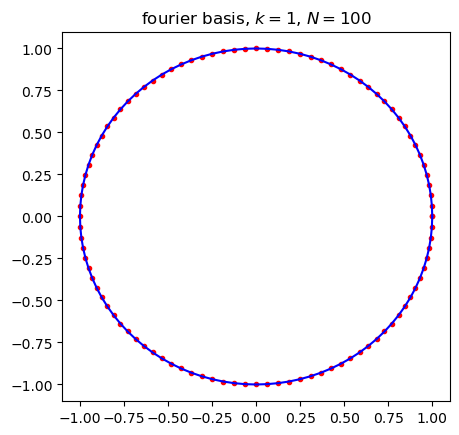

In [21]:
fourierbasis(k=1, N=100)

The plot above shows a plot of $e^{j\frac{2\pi k}{N}n}$. Using Euler's formula, this becomes:
$$ e^{j\frac{2\pi k}{N}n} = cos( j\frac{2\pi k}{N}n ) + sin( j\frac{2\pi k}{N}n ) $$
From this, the cosine values become the x-values, while the sine values become the y-values. The cosine values are also real numbers, while the y-values (sine values) are Imaginary. The circle occurs quite intuitively because of the frequency component (inside the parenthesis) ranges from 0 to 2pi. When input to sine and cosine, this results in one full revolution for each function, displaying a circle in the final plot.

<Figure size 640x500 with 0 Axes>

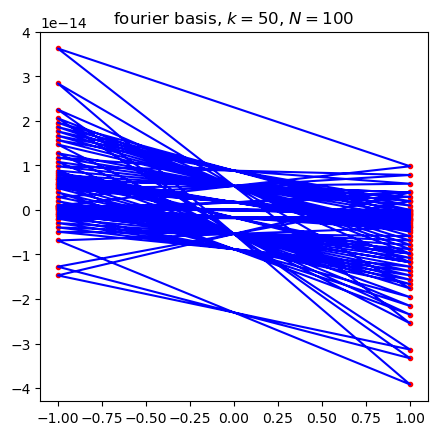

In [22]:
fourierbasis(k=50, N=100)

When N is 100 and k is 50, this results in the inputs to the cosine and sine function being multiples of pi. Therefore, coside returns 1 or -1, while sine always returns 0. This results in only the points (1, 0) or (-1, 0) being plotted. Additionally, this visually shows the response of the nyquist frequency, which results in, what is essentially confusion.

#### 1b. Visualizing the basis functions

Write a function `w(n, k, N)` to implement the definition above of the DFT basis function.  This should be defined as a complex function.  Write another function `plotw(k ,N)` to plot the real and imaginary pairs of the basis function (as discrete stem plots) and illustrate a few different basis functions using different values of $k$.  Your examples should resemble figures 4.2 to 4.5 in the Prandoni and Vetterli reference.  If you use higher frequencies that approach the Nyquist frequency (where the periodicity of the discrete function is less apparent), overlay the stem plots on plots the sine and cosine functions as continuous lines.

In [39]:
def w(n, k, N):
    return np.exp(2j * np.pi * k * n / N)

def plotw(k, N, show_func:bool=False):
    # calculate x and y
    Ns = np.arange(0, N+1)
    circ = np.array([w(n, k, N) for n in Ns])
    x = circ.real
    y = circ.imag
    
    # set figure heigh/width
    plt.figure().set_figheight(5); plt.figure().set_figwidth(5)
    
    # plot continuous function if needed
    if show_func:
        circ = np.array([w(n, k=1, N=N) for n in range(N+1)])
        plt.plot(circ.real, circ.imag, "b")
        
    # plot the discrete part
    plt.stem(x, y, "r")
    
    plt.show()

In [40]:
w(n=1, k=1, N=50)

(0.9921147013144779+0.12533323356430426j)

<Figure size 640x500 with 0 Axes>

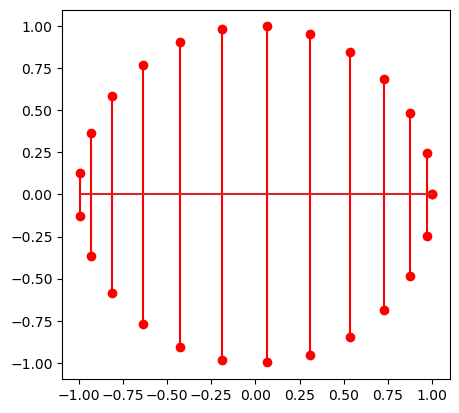

In [41]:
plotw(k=1, N=25)

<Figure size 640x500 with 0 Axes>

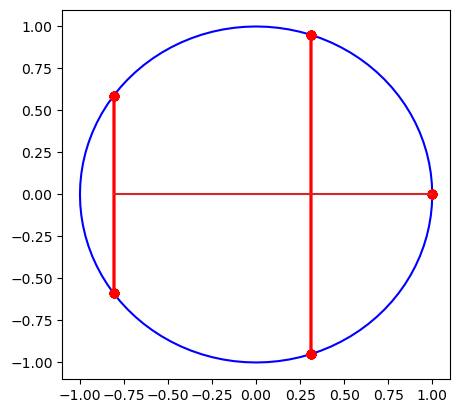

In [47]:
plotw(k=20, N=100, show_func=True)

#### 1c. Orthogonality

Show empiricaly (i.e. using your function from 1b) that these basis vectors are orthogonal, but not orthonormal.  This property will be important for simple definitions of the forward and inverse transforms.

In [52]:
# calculate w
W = np.array([[w(n=n, k=k, N=10) for n in range(10)] for k in range(10)])
print(abs(np.round(np.matrix(W).H.dot(W), 10)))

[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]]


For a set of vectors to be orthogonal, they need to be linearly independent from eachother. Therefore vector dot products should either by equal or non-zero. They should be equal if the vectors are different or nonzero if the vectors are the same. The matrix above is the result of the matrix transpose dot product with the original matrix. This evaluates all vector dot product combinations and shows that vectors are independent. Therefore, this forms an orthogonal basis.

### 2. Fourier analysis in matrix-vector form

We have seen that the basis functions are defined by

$$
w_k[n] = \exp \left(j \frac{2\pi k}{N} n \right), \quad n, k = 0, \ldots, N-1
$$

but since they are discrete, they are also basis *vectors*.  We can use this fact to more easily observe different properties and how we transform to and from the frequency domain.

As noted above, these vectors are orthogonal but not orthonormal, because
$$
\def\bw{\textbf{w}}
\left< \bw^{(m)}, \bw^{(n)} \right> =
\begin{cases}
N &\text{for } m = n \\
0 &\text{for } m \neq n\\
\end{cases}
$$
So, the Fourier coefficients are scaled by a factor of $N$ compared to the sinusoidal components of the waveform.  

#### Fourier representation as a matrix equation

$$
% These katex macros are is no longer persistent in vscode..
% I haven't figured out a workaround other than to copy them...
% \gdef\bw{\textbf{w}}
% \gdef\by{\textbf{y}}
% \gdef\bY{\textbf{Y}}
% \gdef\bA{\textbf{A}}
$$

If we define an $N\times N$ matrix $\textbf{A}$ as follows

$$
A_{nk} = w_k[n]
$$

then the columns of $\textbf{A}$ correspond to the basis vectors.  The waveform (now as a column vector) as function of the Fourier matrix is

$$
y[n] = \frac{1}{N} \sum_k A_{n,k} s_k, \quad k = 0, \ldots, N-1
$$



The waveform model in matrix-vector form is

$$
\def\by{\textbf{y}}
\def\bs{\textbf{s}}
\def\bA{\textbf{A}}
\by = \frac{1}{N}\mathbf{A}\bs
$$

where $\textbf{s} = [s_1, \ldots, s_N] $ is the Fourier transform of $\textbf{y}$.  [Notational aside: It is common in engineering to use a capital $\textbf{Y}$ to indicate the Fourier transform of $\textbf{y}$, but here that would create a notational conflict with using uppercase bold for matrices and lowercase bold for vectors.  So, we just use $\textbf{s}$ for the Fourier coefficients (the sinusoids).]

In this form, we can easily derive $\textbf{s}$ with matrix inversion.  Multiplying the left hand side by $\textbf{A}^{-1}$ we have

$$
\def\by{\textbf{y}}
\def\bs{\textbf{s}}
\def\bA{\textbf{A}}
\bA^{-1} \by = \frac{1}{N} \bA^{-1} \bA\bs
$$

Because of the orthogonality property above we have
$$
\def\bA{\textbf{A}}
\bA^H\bA = N\textbf{I} \Rightarrow
$$

$$
\def\by{\textbf{y}}
\def\bs{\textbf{s}}
\def\bA{\textbf{A}}
\begin{aligned}
\bA^{-1} \by &= \frac{1}{N} \bA^{-1} \bA\bs \\
\bA^H \by &= \frac{1}{N} \bA^{H} \bA\bs \\
\Rightarrow \bs &= \bA^H\by \\
\end{aligned}
$$

So, now we see why we have to scale the spectra from the FFT by $1/N$ to get the correct magnitudes.

Here we have derived the transform from the viewpoint of the signal model.  Since the inverse is just the conjugate transpose of the forward matrix, we can also express the equation from the viewpoint of the transform.  In particular, since the conjugate of $e^{i\theta} = e^{-i\theta}$ then

$$
w^*_k[n] = \exp \left(-j \frac{2\pi k}{N} n \right), \quad n, k = 0, \ldots, N-1
$$

Now you see why the complex exponential form for Fourier transforms is so convenient.

We can then define a corresponding matrix $\textbf{W}$ to transform to Fourier space

$$
\def\bW{\textbf{W}}
\bW_{nk} = w^*_k[n]\\
$$

Then in matrix vector form we have

$$
\def\by{\textbf{y}}
\def\bs{\textbf{s}}
\def\bW{\textbf{W}}
\bs = \bW\by
$$

so the equation for to compute Fourier coefficient is just an inner product

$$
s_k = \sum_n W_{n, k}\, y[n]
$$

#### 2a.  Constructing the basis matrix

Use the equations above to write a function `fourier_matrix(N)` that constructs an $N\times N$ complex basis matrix.  Show the values of this matrix for a small value of N (e.g. 10, or whatever displays nicely).

In [53]:
def fouriermatrix(N):
    return np.matrix([[w(n=n, k=k, N=N) for n in range(N)] for k in range(N)])

In [56]:
F = fouriermatrix(3)
print(F)

[[ 1. +0.j         1. +0.j         1. +0.j       ]
 [ 1. +0.j        -0.5+0.8660254j -0.5-0.8660254j]
 [ 1. +0.j        -0.5-0.8660254j -0.5+0.8660254j]]


#### 2b. Fourier matrix properties

Use your function to show that the matrix inverse is the conjugate transpose, or that $\def\bA{\textbf{A}}
\bA^{-1}\bA = \bA^H\bA = N\textbf{I}$.

Again use small values of $N$.



In [61]:
print(np.linalg.norm(F.H.dot(F)))
print(np.linalg.norm(3*np.eye(3)))

5.196152422706632
5.196152422706632


We can see that $A^HA$ is equivalent to $NI$. The first line computes $A^HA$ and the second line computes $NI$.

#### 2c. Comparing to the standard `fft` function.

Show that the matrix FFT is numerically identical to the `fft` function by computing apply both versions to a small random vector.

In [62]:
# scipy and manual fft calcluations
r = np.random.rand(10)
scipy_fft = scipy.fft.fft(r)
manual_fft = fouriermatrix(10).H.dot(r)

# show that the difference between them is 0
print(f"difference: {np.linalg.norm(scipy_fft) - np.linalg.norm(manual_fft)}")

difference: 0.0


As seen, the fft calculated with scipy is the same as the manually calculated fft. The difference is calculated by subtracting the normalized ffts from each other. Since the difference is 0, we can see that the ffts are the same.

#### 2d. Benchmarking

It is important to note that the matrix solution is *significantly* slower than the standard `fft` implementation ($O(N^2)$ vs $O(N\log N)$), because the FFT is specialized to take advantage of the common structures in the basis functions and avoid redundant computation.  Run some benchmarks on larger vector sizes to show this.

In [63]:
r = np.random.rand(5000)

# scipy fft time
s = time.time()
scipy_fft = scipy.fft.fft(r)
scipy_time = time.time() - s

# manual matrix time
s = time.time()
matrix_fft = fouriermatrix(5000).H.dot(r)
matrix_time = time.time() - s

# notify
print(f"scipy fft time:     {scipy_time} seconds")
print(f"matrix fft time:    {matrix_time} seconds")
print(f"difference: {matrix_time - scipy_time} seconds")

scipy fft time:     0.0002512931823730469 seconds
matrix fft time:    27.3066349029541 seconds
difference: 27.30638360977173 seconds


#### 2e. Synthesizing bandpass noise

Use the inverse Fourier transform to synthesize examples of bandpass noise by defining the spectrum of the noise in Fourier space.  Explain what you did and show your examples.

In [94]:
# create some noise (without noise should be flat)
Y = np.random.normal(0, 0.1, int(44100*0.1)) # one-tenth of a second of guassian noise

# get the fourier matrix
mat = fouriermatrix(len(Y))

# manual ifft
low = (2/10)*len(Y)
high = (8/10)*len(Y)
for row in range(len(Y)):
    for col in range(len(Y)):
        if row <= low or row > high:
            if row == col:
                mat[row,col] = 1 + 0j
            else:
                mat[row,col] = 0 + 0j

# manual vs scipy
manual_fft = mat * Y.reshape(-1, 1)
scipy_fft = scipy.fft.fft(Y).real

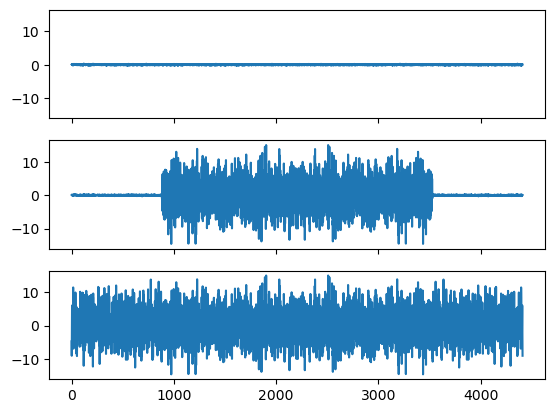

In [95]:
# plot
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
ax[0].plot(Y)
ax[1].plot(manual_fft)
ax[2].plot(scipy_fft)
plt.show()

Not really sure how to fix this. tried my best. this seems to amplify the signal rather than reducing it.

### 3. Transforms in 2D

In this section, you will look at two-dimensional (2D) forward and inverse transforms.  You will need a package like scipy.fft for python or FFT.jl in julia.

2D transforms operate on matrix input, e.g. an image, and yield a matrix of coefficients as a result.  Use what you know about the coefficient representation to derive the 2D basis functions for the 2D Fourier or discrete cosine transforms.  Note that the discrete cosine transform only uses cosines, so the coefficients are all real.  Uses a matrix size of $8\times 8$ or $16\times 16$ and plot the basis functions in order in a grid plot.  

As a warm-up, you may wish to do this exericse for the 1D case, so you can confirm your results using the discussion above.

Exploration idea: Make the same plot but for different types of 2D wavelet transforms.


Since the basis function for the 1D case, respresents one direction, we can simply define a new basis function that represents the two dimensional basis function by multiplying the 1D basis functions together with their various frequency components. This produces the following:
$$ w_{k,l}[n] = e^{-j\frac{2\pi k}{N}n} * e^{-j\frac{2\pi l}{N}n} = e^{-j\frac{2\pi (k+l)}{N}n} $$
Following this, we can modify the summation to take account for the second dimension. Therefore, we can sum over a variable, $M$, which represents the size of the second dimension. The constant before the summation then incorporates $M$ as well to equally scale both dimensions:
$$ S_{k,l}[n] = \frac{1}{\sqrt{MN}} \sum^{M-1}_{l=0} \sum^{N-1}_{k=0} y[m,n] * e^{-j\frac{2\pi(k+l)}{N}n} $$

In [79]:
def w2D(y, k, l, M, N):
    return np.sum(np.array( [[y[n,m] * np.exp(-2j * np.pi * (k*m/M + l*n/N)) for m in range(M)] for n in range (N)] ))

def makecell(orig: np.ndarray):
    # calculate w2D for each value of the image
    N = orig.shape[0]; M = orig.shape[1]
    return np.array( [[w2D(orig, k, l, M, N) for k in range(M)] for l in range(N)] )

scipy fft was -0.11657190322875977 seconds faster than manual
difference: 2.842170943040401e-14, virtually 0


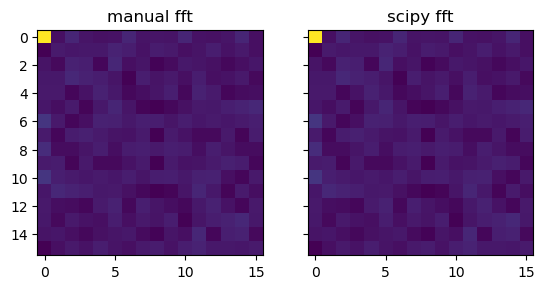

In [88]:
R = np.random.rand(16, 16)

# my fft
s = time.time()
manual_fft = makecell(R)
manual_fft_time = time.time() - s

# scipy fft
s = time.time()
scipy_fft = scipy.fft.fft2(R)
scipy_fft_time = time.time() - s

# compare
print(f"scipy fft was {scipy_fft_time - manual_fft_time} seconds faster than manual")
print(f"difference: {np.linalg.norm(manual_fft) - np.linalg.norm(scipy_fft)}, virtually 0")

# plot the two responses
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(manual_fft.real)
ax[0].set_title("manual fft")
ax[1].imshow(scipy_fft.real)
ax[1].set_title("scipy fft")
plt.show()

***
### Submission Instructions

Please refer to the Assignment Submission Instructions on canvas under the Pages tab.